# **Import headers**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

##  SKlearn libs for regressions
from sklearn import metrics, linear_model
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

##Importing Libraries for Neural Nets
import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation
import math
from tqdm import tqdm
import pickle 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from tqdm.keras import TqdmCallback

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 100) 

In [ ]:
!pip install matplotlib --upgrade
!pip install seaborn --upgrade
# !pip install matplotlib==3.1.3

# **Explore neural network models**

In [5]:
cats = ['rec.sport.hockey', 'sci.electronics', 'rec.autos']
vectorizer = TfidfVectorizer()

#### **Fetch and prepare raw data**

In [6]:
news_train = np.array(fetch_20newsgroups(subset='train', categories=cats).data)
news_test = np.array(fetch_20newsgroups(subset='test', categories=cats).data)
news = np.concatenate((news_train, news_test), axis = 0) # Concatenating to ensure common vocabulary

X = vectorizer.fit_transform(news).toarray()
X_train = X[:1785].copy()
X_test = X[1785:].copy()

y_train = fetch_20newsgroups(subset='train', categories=cats).target
y_test = fetch_20newsgroups(subset='test', categories=cats).target

In [7]:
# print(news_train[0])

#### **Fetch and prepare cleaned data (without headers and footers)**

In [ ]:
news_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=cats).data
news_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=cats).data

X_train = vectorizer.fit_transform(news_train).toarray()
X_test = vectorizer.transform(news_test).toarray()

y_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=cats).target
y_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=cats).target

In [ ]:
# print(news_train[0])

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1785, 19663)
(1188, 19663)
(1785,)
(1188,)


#### **Convert the TF-IDF vectors from sparse to dense, and make labels one-hot**

In [12]:
y_train
# class 0: rec.auto, class 1: rec.sport.hockey, class 2: rec.sci.electronics

array([1, 0, 2, ..., 0, 1, 2])

In [29]:
# print value_counts of each class in training data
# np.array(np.unique(y_train, return_counts=True)).T

In [13]:
y_train_oh= to_categorical(y_train)
y_test_oh = to_categorical(y_test)
y_train_oh = y_train_oh.astype(int)
y_test_oh = y_test_oh.astype(int)

In [31]:
# y_train_oh
# Labels converted to OneHot

#### **Some tunable parameters**

In [14]:
act = 'tanh'
# batch_len = 32
opt = 'adam'
epoch = 20
val_split = 0.2

#### **Explore the impact of batch size**

In [9]:
def count_misclassified_points(y_true, y_pred):
    count = 0
    # assuming len(y_true) == len(y_pred)
    for i in range(len(y_true)):
        if not np.array_equal(y_true[i], y_pred[i]):
            count += 1
    return count

In [10]:
# function to make the predictions one-hot
def make_one_hot(y):
    n_dims = len(y[0])
    for i in range(len(y)):
        max_index = y[i].argmax()
        y[i] = np.zeros(n_dims)
        y[i][max_index] = 1
    y = y.astype(int)
    return y

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = val_split, random_state = 0)

In [15]:
average_losses = dict()
for batch_len in [8, 16, 32, 64, 128, 256, 512, 1024]:
    losses = []
    # Repeat training 5 times and take the average validation loss
    for _ in tqdm(range(5)):
        # Define the model architecture
        keras.backend.clear_session()
        model = Sequential()
        model.add(Dense(32, activation = act, input_dim = X_train.shape[1]))
        model.add(Dense(32, activation = act))
        model.add(Dense(32, activation = act))
        model.add(Dense(3, activation = 'softmax')) # for multi-class classification

        # Train the model
        model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
        history = model.fit(X_train, y_train_oh, epochs = epoch, batch_size = batch_len, verbose = 0)

        # Compute and store the validation loss (# misclassified points in this case)
        y_pred_valid = model.predict(X_valid)
        y_pred_valid = make_one_hot(y_pred_valid)

        valid_loss = count_misclassified_points(y_pred_valid, y_valid)
        losses.append(valid_loss)
    
    # Compute and store the average loss for this batch size
    average_loss = np.mean(losses)
    average_loss = round(average_loss, 1)
    average_losses[batch_len] = average_loss

100%|██████████| 5/5 [00:42<00:00,  8.45s/it]


# **Plots**

In [4]:
print(average_losses)

{8: 36.8, 16: 34.9, 32: 32.4, 64: 33.2, 128: 33.2, 256: 34.0, 512: 34.6, 1024: 37.8}


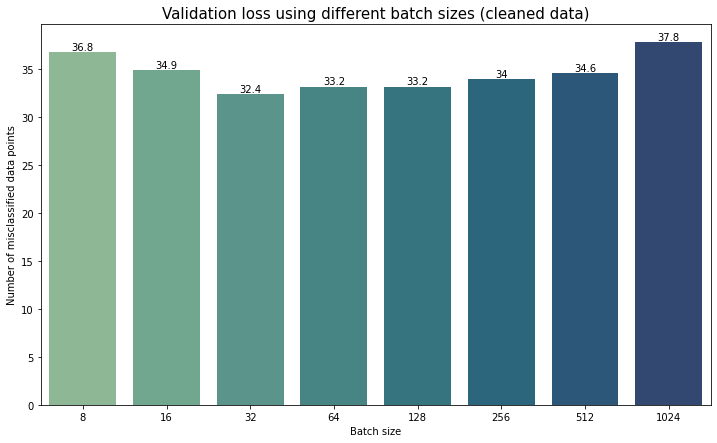

In [12]:
# Plot the validation loss for different batch sizes 
keys = list(average_losses_valid.keys())
values = list(average_losses_valid.values())
plt.figure(figsize = (12, 7))
ax = sns.barplot(x = keys, y = values, palette = 'crest')
ax.bar_label(ax.containers[0])
ax.set(xlabel='Batch size', ylabel='Number of misclassified data points')
ax.set_title( "Validation loss using different batch sizes (cleaned data)", size = 15)
plt.show()

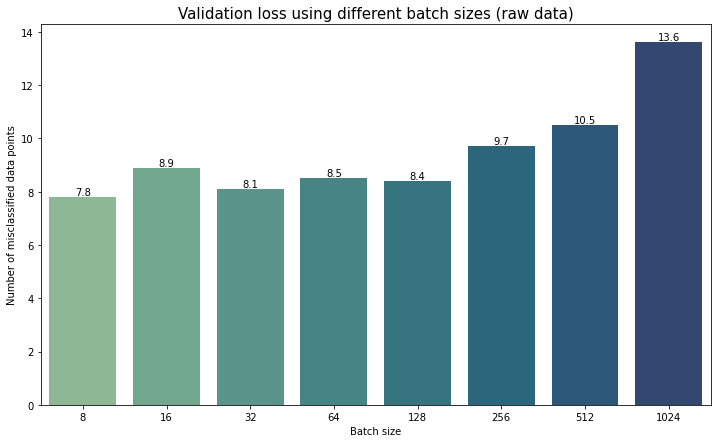

In [28]:
# Plot the validation loss for different batch sizes 
keys = list(average_losses_valid.keys())
values = list(average_losses_valid.values())
plt.figure(figsize = (12, 7))
ax = sns.barplot(x = keys, y = values, palette = 'crest')
ax.bar_label(ax.containers[0])
ax.set(xlabel='Batch size', ylabel='Number of misclassified data points')
ax.set_title( "Validation loss using different batch sizes (raw data)", size = 15)
plt.show()

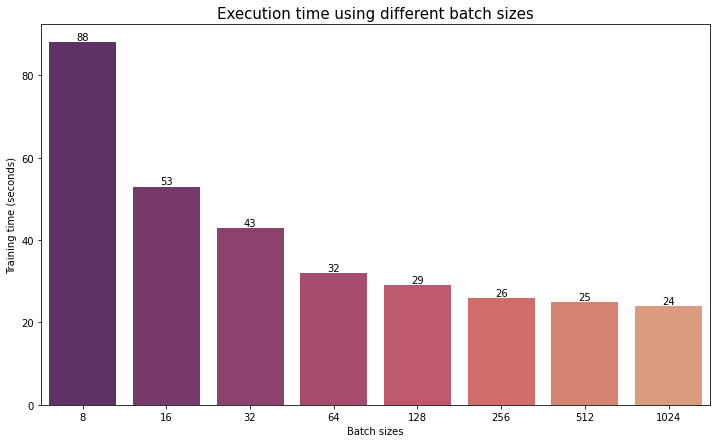

In [15]:
# Plot the execution time for different batch sizes 
keys = list(batch_exec_time.keys())
values = list(batch_exec_time.values())
plt.figure(figsize = (12, 7))
ax = sns.barplot(x = keys, y = values, palette = 'flare_r')
ax.bar_label(ax.containers[0])
ax.set(xlabel='Batch sizes', ylabel='Training time (seconds)')
ax.set_title( "Execution time using different batch sizes", size = 15)
plt.show()

# **Pickling the losses**

In [31]:
average_losses_valid

{8: 7.8, 16: 8.9, 32: 8.1, 64: 8.5, 128: 8.4, 256: 9.7, 512: 10.5, 1024: 13.6}

In [32]:
with open('average_losses.pickle', 'wb') as handle:
    pickle.dump(average_losses, handle)

with open('average_losses_valid.pickle', 'wb') as handle:
    pickle.dump(average_losses_valid, handle)

In [2]:
with open('average_losses.pickle', 'rb') as handle:
    average_losses = pickle.load(handle)

with open('average_losses_valid.pickle', 'rb') as handle:
    average_losses_valid = pickle.load(handle)



1.   First upgrade matplotlib to latest version
2.   Restart runtime
3.   Import packages
4.   Upload and open pickled loss files 
5.   Plot the relevant graphs



# **Other experiments**

In [44]:
# Save and zip model
model_name = 'modelr_98_tanh_8_20'
model.save('modelr_98_tanh_8_20')
!zip -r modelr_98_tanh_8_20.zip modelr_98_tanh_8_20

INFO:tensorflow:Assets written to: modelr_98_tanh_8_20/assets
  adding: modelr_98_tanh_8_20/ (stored 0%)
  adding: modelr_98_tanh_8_20/saved_model.pb (deflated 88%)
  adding: modelr_98_tanh_8_20/assets/ (stored 0%)
  adding: modelr_98_tanh_8_20/keras_metadata.pb (deflated 89%)
  adding: modelr_98_tanh_8_20/variables/ (stored 0%)
  adding: modelr_98_tanh_8_20/variables/variables.data-00000-of-00001 (deflated 23%)
  adding: modelr_98_tanh_8_20/variables/variables.index (deflated 66%)
